# Dynamic Time Warping Clustering

This will be taking our raw and cdc data to cluster states by the DTW metric

## importing data

In [144]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px # choropleth maps
from IPython.display import Image
import os
import sys
import json
# plotly maps
# import plotly.figure_factory as ff
# from urllib.request import urlopen

# sys.path.append(os.path.abspath("C:/Users/Alex/Documents/My Data Files/COVID Research/analysis/mention_2_hashtag.py"))

# from analysis.functions.mention_2_hashtag import * 
# from analysis.functions.datamanip import *

# n grams
from sklearn.feature_extraction.text import CountVectorizer

raw = pd.read_csv('../final/flair.joined.tweets.csv')

# changing date to more readable format
raw['created_at'] = pd.to_datetime(raw['created_at'])

# getting seperated date and time columns
raw['date'] = raw['created_at'].dt.date
raw['week'] = raw['created_at'].dt.week
raw['time'] = raw['created_at'].dt.time
raw['hour'] = raw['created_at'].dt.hour

min_wk = raw['week'].min()
max_wk = raw['week'].max()

min_date = raw['date'].min()
max_date = raw['date'].max()

# changing na to None
raw = raw.fillna('None')

raw = raw[raw['sentiment'] != 'None']

raw['is_negative'] = [1 if 'NEGATIVE' in str(sent) else 0 for sent in raw['sentiment']]
raw['is_positive'] = [1 if 'POSITIVE' in str(sent) else 0 for sent in raw['sentiment']]


def convert_fips(unknown_fips_list, fin):
    
    def convert(fipsline):
        name, postal, fips= fipsline.strip().split('\t')

        return {fips: name}

    fips_dict = {f: n 
                for dic in [convert(line)for line in open(fin, 'r')]
                for f, n in dic.items()}

    return [fips_dict[f'{unknown:02d}'] for unknown in unknown_fips_list]

raw = raw[raw['statefips'] != 'None']

raw['state_name'] = convert_fips([int(float(fips)) for fips in raw['statefips']],
                     '../analysis/functions/state.fips.txt')

us_state_abbrev = json.load(open('../final/state_abbreviations.json'))

raw['state_abv'] = [us_state_abbrev[s] for s in raw['state_name']]

raw['fips'] = [f'{int(float(state)):02d}{int(float(county)):03d}' for i, state, county in raw[['statefips', 'countyfips']].itertuples()]
raw['count'] = 1
# raw.head()

all_splits = pd.to_datetime(['2020-03-05', '2020-03-26', '2020-05-01'])
raw['stage'] = ['s:1' if date < all_splits[0] else 's:2' if date < all_splits[1] else 's:3' if date < all_splits[2] else 's:4' for date in raw['date']]



#########################
# thresholds
thresholds = [0.8, 0.9, 0.95]
for thresh in thresholds:
    raw[f't:{thresh}'] = [1 if float(conf) > thresh else 0 for conf in raw['sent_confidence']]

col = 't:0.8'
raw['category'] = ['NEUT' if t == 0 else 'POS' if p == 1 else 'NEG' for i, n, p, t in raw[['is_negative', 'is_positive', col]].itertuples()]
raw['is_neutral'] = [1 if cat == 'NEUT' else 0 for cat in raw['category']]
raw['is_positive'] = [1 if cat == 'POS' else 0 for cat in raw['category']]
raw['is_negative'] = [1 if cat == 'NEG' else 0 for cat in raw['category']]

raw['is_neutral2'] = raw['is_neutral']
raw['is_positive2'] = raw['is_positive']
raw['is_negative2'] = raw['is_negative']

raw['is_neutral3'] = raw['is_neutral']
raw['is_positive3'] = raw['is_positive']
raw['is_negative3'] = raw['is_negative']

##################
# cdc

keywords = ['social distancing', 'social distance', 'physical distance', '6 feet', 'stay at home', 'school isolation', 'isolation', 'stay home', 'avoid touching', 'mask', 'covering', 'face shield', 'wear a mask', 'surgical mask', 'N95 respirator', 'wearing gloves', 'face shields', 'facial covering', 'skin protection', 'eye protection', 'ppe', 'wash hands', 'hand sanitizer', 'disinfect', 'clean', 'detergent', 'handwashing', 'hand hygiene', 'prevention hygiene', 'sprays', 'concentrates', 'wipes', 'routine cleaning', 'bleach solution', 'test', 'business closure']

topics = []
indexes = {i:0 for i in range(len(raw.index))}

for i, topic in enumerate(keywords):
    topics.append([1 if topic in text else 0 for text in raw['ogtext']])

for i, kw in enumerate(topics):
    for data_ind, value in enumerate(topics[i]):
        indexes[data_ind] += value

raw['in_cdc'] = [indexes[i] if 0 <= indexes[i] <= 1 else 1 for i in indexes]

cdc = raw[raw['in_cdc'] == 1]

cdc_splits = pd.to_datetime(['2020-03-12', '2020-04-20', '2020-05-14'])
cdc['stage'] = ['s:1' if date < cdc_splits[0] else 's:2' if date < cdc_splits[1] else 's:3' if date < cdc_splits[2] else 's:4' for date in cdc['date']]

# print(f'there are a total of {len(cdc.index)} tweets after subsetting for cdc keywords')
# print(raw)
# print(cdc)
print('loaded...')

<ipython-input-144-4f2b2bae5c0e>:28: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  raw['week'] = raw['created_at'].dt.week
loaded...
<ipython-input-144-4f2b2bae5c0e>:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdc['stage'] = ['s:1' if date < cdc_splits[0] else 's:2' if date < cdc_splits[1] else 's:3' if date < cdc_splits[2] else 's:4' for date in cdc['date']]


In [3]:
raw.head()

,id_str,created_at,follower_count,friends_count,statefips,countyfips,countyname,is_urban,ogtext,cleantext,...,t:0.95,category,is_neutral,is_neutral2,is_positive2,is_negative2,is_neutral3,is_positive3,is_negative3,in_cdc
0,id:1226763665036075008,2020-02-10 07:03:44+00:00,270.0,539.0,32.0,3.0,Clark,1,having a mocha and avoiding coronavirus at the...,have mocha avoid coronavirus airport,...,0,POS,0,0,1,0,0,1,0,0
1,id:1226763937317818368,2020-02-10 07:04:49+00:00,199.0,216.0,36.0,81.0,Queens,1,our hearts beat with china,heart beat china,...,0,POS,0,0,1,0,0,1,0,0
2,id:1226764107958734851,2020-02-10 07:05:30+00:00,235.0,130.0,4.0,13.0,Maricopa,1,people stop my sister in the street to make fu...,people stop sister street fun wearing mask s a...,...,0,POS,0,0,1,0,0,1,0,1
3,id:1226765442548719616,2020-02-10 07:10:48+00:00,60008.0,51176.0,5.0,119.0,Pulaski,0,coronavirus death toll surpasses the number o...,coronavirus death toll surpass number fatal...,...,1,NEG,0,0,0,1,0,0,1,0
4,id:1226765540229861376,2020-02-10 07:11:11+00:00,60008.0,51176.0,5.0,119.0,Pulaski,0,coronavirus cases aboard japanese cruise ship...,coronavirus case aboard japanese cruise shi...,...,1,NEG,0,0,0,1,0,0,1,0


In [4]:
cdc.head()

,id_str,created_at,follower_count,friends_count,statefips,countyfips,countyname,is_urban,ogtext,cleantext,...,t:0.95,category,is_neutral,is_neutral2,is_positive2,is_negative2,is_neutral3,is_positive3,is_negative3,in_cdc
2,id:1226764107958734851,2020-02-10 07:05:30+00:00,235.0,130.0,4.0,13.0,Maricopa,1,people stop my sister in the street to make fu...,people stop sister street fun wearing mask s a...,...,0,POS,0,0,1,0,0,1,0,1
6,id:1226766434052669442,2020-02-10 07:14:44+00:00,573.0,2550.0,6.0,37.0,Los Angeles,1,clean hands is paramount in preventing the spr...,clean hand paramount prevent spread flu corona...,...,1,POS,0,0,1,0,0,1,0,1
9,id:1226767736388239360,2020-02-10 07:19:55+00:00,87.0,176.0,6.0,1.0,Alameda,1,japan keeps people on cruise ship and announce...,japan keep people cruise ship announce case to...,...,1,NEG,0,0,0,1,0,0,1,1
27,id:1226325348247310337,2020-02-09 02:02:01+00:00,1196.0,1661.0,39.0,117.0,Morrow,0,if they pulled the stuff in the sixties and se...,pulled stuff sixty seventy asse handed throw j...,...,1,NEG,0,0,0,1,0,0,1,1
54,id:1232651646775234560,2020-02-26 13:00:28+00:00,63557.0,1027.0,12.0,86.0,Miami-Dade,1,in preparation for the possibility of local de...,preparation possibility local detection prepar...,...,0,NEG,0,0,0,1,0,0,1,1


In [20]:
raw.columns

Index(['id_str', 'created_at', 'follower_count', 'friends_count', 'statefips',
       'countyfips', 'countyname', 'is_urban', 'ogtext', 'cleantext',
       'mentions', 'hashtags', 'pos', 'ner', 'sentiment', 'sent_confidence',
       'date', 'week', 'time', 'hour', 'is_negative', 'is_positive',
       'state_name', 'state_abv', 'fips', 'count', 'stage', 't:0.8', 't:0.9',
       't:0.95', 'category', 'is_neutral', 'is_neutral2', 'is_positive2',
       'is_negative2', 'is_neutral3', 'is_positive3', 'is_negative3',
       'in_cdc'],
      dtype='object')

## getting some basic statistics for our two datasets

In [111]:
## getting stats and printing statements for examination

cats = 'negative neutral positive'.split(' ')

for cat in cats:

    print(f'{cat}:')

    print('raw data ...')
    raw_agg = raw.groupby(['state_abv', 'stage']).agg({f'is_{cat}2':'sum', f'is_{cat}':'mean'}).reset_index()


    raw_agg = raw_agg[raw_agg[f'is_{cat}2'] > 15]


    print(f'n counties = {len(raw_agg.groupby(["state_abv"]).agg({f"is_{cat}":"count"}).reset_index().index)}')
    print(f'mean stage = {raw_agg.groupby(["state_abv"]).agg({f"is_{cat}":"count"}).reset_index()[f"is_{cat}"].describe()}')
    print(f'mean= {raw_agg[f"is_{cat}"].mean()}, std= {raw_agg[f"is_{cat}"].std()}')


    print()
    print('cdc data ...')
    cdc_agg = cdc.groupby(['state_abv', 'stage']).agg({f'is_{cat}2':'sum', f'is_{cat}':'mean'}).reset_index()


    cdc_agg = cdc_agg[cdc_agg[f'is_{cat}2'] > 15]


    print(f'n counties = {len(cdc_agg.groupby(["state_abv"]).agg({f"is_{cat}":"sum"}).reset_index().index)}')
    print(f'mean stage = {cdc_agg.groupby(["state_abv"]).agg({f"is_{cat}":"count"}).reset_index()[f"is_{cat}"].describe()}')
    print(f'mean= {cdc_agg[f"is_{cat}"].mean()}, std= {cdc_agg[f"is_{cat}"].std()}')

    print()
    print('-------------------------')
    print()



negative:
raw data ...
n counties = 52
mean stage = count    52.0
mean      4.0
std       0.0
min       4.0
25%       4.0
50%       4.0
75%       4.0
max       4.0
Name: is_negative, dtype: float64
mean= 0.5695728131406632, std= 0.06503213249811124

cdc data ...
n counties = 45
mean stage = count    45.000000
mean      3.933333
std       0.447214
min       1.000000
25%       4.000000
50%       4.000000
75%       4.000000
max       4.000000
Name: is_negative, dtype: float64
mean= 0.6206240091404913, std= 0.07926986053614529

-------------------------

neutral:
raw data ...
n counties = 51
mean stage = count    51.000000
mean      3.686275
std       0.836426
min       1.000000
25%       4.000000
50%       4.000000
75%       4.000000
max       4.000000
Name: is_neutral, dtype: float64
mean= 0.1326141750933576, std= 0.014980906157825736

cdc data ...
n counties = 35
mean stage = count    35.000000
mean      3.228571
std       1.031439
min       1.000000
25%       2.500000
50%       4.00000

# Clustering pre-processing

## finding states that fit qualifiers

state must have more than 15 tweets and have a proportion of sentiment for each stage of the 4 found.

In [112]:
# finding states that have all time series stage marks

import numpy as np

raw2cnt = []
cdc2cnt = []

cats = 'negative neutral positive'.split(' ')

for i, cat in enumerate(cats):
    # find counts for each state

    raw_agg = raw.groupby(['state_abv', 'stage']).agg({f'is_{cat}2':'sum', f'is_{cat}':'mean'}).reset_index()
    raw_agg = raw_agg[raw_agg[f'is_{cat}2'] > 15]
    raw_cnt = raw_agg.groupby(["state_abv"]).agg({f"is_{cat}":"count"}).reset_index()

    raw2cnt.append({state: n for _, state, n in raw_cnt.itertuples()})

    cdc_agg = cdc.groupby(['state_abv', 'stage']).agg({f'is_{cat}2':'sum', f'is_{cat}':'mean'}).reset_index()
    cdc_agg = cdc_agg[cdc_agg[f'is_{cat}2'] > 15]
    cdc_cnt = cdc_agg.groupby(["state_abv"]).agg({f"is_{cat}":"count"}).reset_index()

    cdc2cnt.append({state: n for _, state, n in cdc_cnt.itertuples()})

state2keep_raw = {}
state2keep_cdc = {}

for state in raw['state_abv'].unique():
    # make sure each state has enough data to fill all 4 stages

    if state in raw2cnt[0] and state in raw2cnt[1] and state in raw2cnt[2]:
        if raw2cnt[0][state] == 4 and raw2cnt[1][state] == 4 and raw2cnt[2][state] == 4:
            state2keep_raw[state] = 1

    if state in cdc2cnt[0] and state in cdc2cnt[1] and state in cdc2cnt[2]:
        if cdc2cnt[0][state] == 4 and cdc2cnt[1][state] == 4 and cdc2cnt[2][state] == 4:
            state2keep_cdc[state] = 1

print(f'n raw states = {len(state2keep_raw)}, n cdc states = {len(state2keep_cdc)}')


n raw states = 44, n cdc states = 20


## vectorizing our data into

[state
... 
state]

where state is 

[negative [stage1 stage2 stage3 stage4]
neutral [stage1 stage2 stage3 stage4]
positive [stage1 stage2 stage3 stage4]]

In [113]:
# vectorizing data
# need a matrix for each state
# matrix will be 3 deep (one for each sentiment)
# x is stage step, y is proportion of sentiment at x

cats = 'negative neutral positive'.split(' ')

raw_states = np.zeros((len(state2keep_raw), 3, 4))
cdc_states = np.zeros((len(state2keep_cdc), 3, 4))

state2index_raw = {state: i for i, state in enumerate(state2keep_raw)}
state2index_cdc = {state: i for i, state in enumerate(state2keep_cdc)}

for state, index in state2index_raw.items():
    for row, cat in enumerate(cats):
        sent = raw[raw['state_abv'] == state].groupby(['stage']).agg({f'is_{cat}':'mean'}).reset_index()
        for stage, p in sent.groupby('stage'):
            col = int(stage.split(':')[1]) - 1
            raw_states[index, row, col] = p[f'is_{cat}'].values[0]

for state, index in state2index_cdc.items():
    for row, cat in enumerate(cats):
        sent = cdc[cdc['state_abv'] == state].groupby(['stage']).agg({f'is_{cat}':'mean'}).reset_index()
        for stage, p in sent.groupby('stage'):
            col = int(stage.split(':')[1]) - 1
            cdc_states[index, row, col] = p[f'is_{cat}'].values[0]

cdc_states[0:3]

array([[[0.70788705, 0.56614626, 0.52369668, 0.55824423],
        [0.10516066, 0.15283484, 0.15876777, 0.14518852],
        [0.18695229, 0.2810189 , 0.31753555, 0.29656725]],

       [[0.73360656, 0.53820598, 0.63414634, 0.65188834],
        [0.11065574, 0.18604651, 0.13821138, 0.14942529],
        [0.1557377 , 0.27574751, 0.22764228, 0.19868637]],

       [[0.71939044, 0.55864627, 0.57487923, 0.60961351],
        [0.10825013, 0.1488178 , 0.14699793, 0.13835661],
        [0.17235943, 0.29253593, 0.27812284, 0.25202988]]])

# Clustering and graphs

## raw dataset

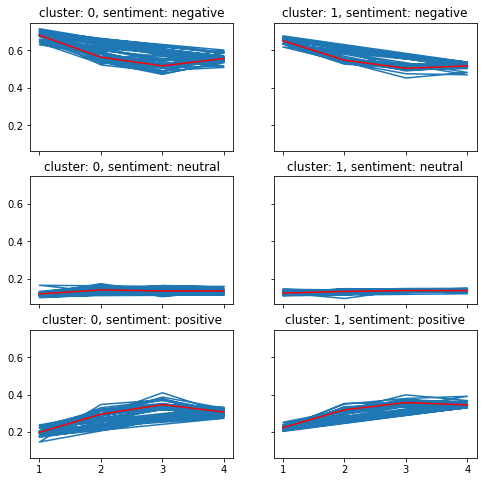

In [197]:
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt
%matplotlib inline

## clustering the data

n_cluster = 2

try:
    from os import mkdir
    mkdir('../clustering/raw_graphs/')
except:
    pass

try:
    mkdir(f'../clustering/raw_graphs/n{n_cluster}')
except:
    pass


kmeans = TimeSeriesKMeans(n_clusters=n_cluster, max_iter=10, metric="dtw", random_state=0).fit(raw_states)
kmeans_p = kmeans.predict(raw_states)

state2cluster_raw = {state: kmeans_p[state2index_raw[state]] for state in state2keep_raw}

# print(kmeans.cluster_centers_)
# print(state2cluster_raw)

## converting data into dataframe for plotting

raw_state_df = []
cats = 'negative neutral positive'.split(' ')

for state, index in state2index_raw.items():
    for cat in cats:
        sent = raw[raw['state_abv'] == state].groupby(['stage']).agg({f'is_{cat}':'mean'}).reset_index()
        
        for stage, p in sent.groupby('stage'):
            row = {"state":state, "sentiment":cat, 'stage': int(stage.split(":")[1]), 'proportion':p[f'is_{cat}'].values[0]}
            raw_state_df.append(row)

raw_state_df = pd.DataFrame(raw_state_df)
clusters = pd.DataFrame([{"state":state, "cluster":cluster} for state, cluster in state2cluster_raw.items()])
raw_state_df = pd.merge(raw_state_df, clusters, on = 'state')

# raw_state_df.head()

## plotting by clusters

fig, ax = plt.subplots(nrows=3, ncols=n_cluster, figsize=(n_cluster*4, 8), sharey = True, sharex = True)

for cluster, df in raw_state_df.groupby(['cluster']):
    for i, (sentiment, states) in enumerate(df.groupby(['sentiment'])):
        ax[i, cluster].plot('stage', 'proportion', data = states)
        ax[i, cluster].set_title(f'cluster: {cluster}, sentiment: {sentiment}')
        ax[i, cluster].plot([1, 2, 3, 4], kmeans.cluster_centers_[cluster, i, :], color = 'red')

fig.savefig(f'../clustering/raw_graphs/n{n_cluster}/cluster.graphs.png')

fig

In [199]:
pl_map = px.choropleth(raw_state_df.groupby(['state']).agg({'cluster':'max'}).reset_index(), locations='state', color='cluster', 
                     scope="usa", locationmode="USA-states", hover_data=['cluster'])

pl_map.write_image(f'../clustering/raw_graphs/n{n_cluster}/cluster.map.png', engine="kaleido", width=800, height=800)

pl_map.show()

## cdc dataset

just saving, not printing

In [196]:
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt
%matplotlib inline

## clustering the data

for n_cluster in [2, 3, 4, 5, 6, 7]:

    try:
        from os import mkdir
        mkdir('../clustering/cdc_graphs/')
    except:
        pass

    try:
        mkdir(f'../clustering/cdc_graphs/n{n_cluster}')
    except:
        pass


    kmeans = TimeSeriesKMeans(n_clusters=n_cluster, max_iter=10, metric="dtw", random_state=0).fit(cdc_states)
    kmeans_p = kmeans.predict(cdc_states)

    state2cluster_cdc = {state: kmeans_p[state2index_cdc[state]] for state in state2keep_cdc}

    # print(kmeans.cluster_centers_)
    # print(state2cluster_raw)

    ## converting data into dataframe for plotting

    cdc_state_df = []
    cats = 'negative neutral positive'.split(' ')

    for state, index in state2index_cdc.items():
        for cat in cats:
            sent = raw[raw['state_abv'] == state].groupby(['stage']).agg({f'is_{cat}':'mean'}).reset_index()
            
            for stage, p in sent.groupby('stage'):
                row = {"state":state, "sentiment":cat, 'stage': int(stage.split(":")[1]), 'proportion':p[f'is_{cat}'].values[0]}
                cdc_state_df.append(row)

    cdc_state_df = pd.DataFrame(cdc_state_df)
    clusters = pd.DataFrame([{"state":state, "cluster":cluster} for state, cluster in state2cluster_cdc.items()])
    cdc_state_df = pd.merge(cdc_state_df, clusters, on = 'state')

    # raw_state_df.head()

    ## plotting by clusters

    fig, ax = plt.subplots(nrows=3, ncols=n_cluster, figsize=(n_cluster*4, 8), sharey = True, sharex = True)

    for cluster, df in cdc_state_df.groupby(['cluster']):
        for i, (sentiment, states) in enumerate(df.groupby(['sentiment'])):
            ax[i, cluster].plot('stage', 'proportion', data = states)
            ax[i, cluster].set_title(f'cluster: {cluster}, sentiment: {sentiment}')
            ax[i, cluster].plot([1, 2, 3, 4], kmeans.cluster_centers_[cluster, i, :], color = 'red')

    fig.savefig(f'../clustering/cdc_graphs/n{n_cluster}/cluster.graphs.png')


    pl_map = px.choropleth(cdc_state_df.groupby(['state']).agg({'cluster':'max'}).reset_index(), locations='state', color='cluster', 
                        scope="usa", locationmode="USA-states", hover_data=['cluster'])

    pl_map.write_image(f'../clustering/cdc_graphs/n{n_cluster}/cluster.map.png', engine="kaleido", width=800, height=800)